<h1 style="text-align:center;">Data Science & Society Thesis</h1>
<h3 style="text-align:center;">FORECASTING CRYPTO PRICE  PEAKS: REGRESSION – BASED </h3>
<h3 style="text-align:center;">TIME – UNTIL – NEW - HIGH </h3>
<h3 style="text-align:center;">PREDICTIONS</h3>
<h5 style="text-align:center;"> ELEFTHERIOS DIAMANTIDIS</h5>

---

<h1 style="text-align:center;"> Exploratory Data Analysis </h1>

### **Step 1:** Import Libraries

In [ ]:
# Import Basic Libraries
# type: ignore
import pandas as pd
import numpy as np
import matplotlib.pylab as plt                                                              
import seaborn as sns                                                                        
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Prevent line-wrapping

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

### **Step 2:** Import data

In [2]:
df_btc = pd.read_csv("data/final_data_btc.csv")
df_btc['coin'] = 'BTC'
df_btc = df_btc.rename(columns={"Date":"date"})
df_btc["date"] = pd.to_datetime(df_btc["date"])
df_btc['Date'] = df_btc['date'].dt.date
df_btc['date'] = df_btc['date'].dt.date
df_btc = df_btc.set_index('Date')
print(df_btc.head())

                  date    Open    High     Low   Close  Volume  tunh coin
Date                                                                     
2010-07-17  2010-07-17  0.0500  0.0500  0.0500  0.0500     0.0   1.0  BTC
2010-07-18  2010-07-18  0.0858  0.0858  0.0858  0.0858     0.0  82.0  BTC
2010-07-19  2010-07-19  0.0808  0.0808  0.0808  0.0808     0.0  81.0  BTC
2010-07-20  2010-07-20  0.0747  0.0747  0.0747  0.0747     0.0   1.0  BTC
2010-07-21  2010-07-21  0.0792  0.0792  0.0792  0.0792     0.0  79.0  BTC


In [3]:
df_btc.shape

(5381, 8)

In [5]:
df_paxg = pd.read_csv("data/final_data_paxg.csv")
df_paxg['coin'] = 'PAXG'
df_paxg = df_paxg.rename(columns={"Date":"date"})
df_paxg["date"] = pd.to_datetime(df_paxg["date"])
df_paxg['Date'] = df_paxg['date'].dt.date
df_paxg['date'] = df_paxg['date'].dt.date
df_paxg = df_paxg.set_index('Date')
print(df_paxg.head())

                  date         Open         High          Low        Close   Volume  tunh  coin
Date                                                                                           
2019-09-26  2019-09-26  1522.969238  1540.213257  1499.900024  1516.510620  5337186   1.0  PAXG
2019-09-27  2019-09-27  1515.437378  1547.361206  1502.289062  1528.739990  2583554   1.0  PAXG
2019-09-28  2019-09-28  1525.926392  1553.475098  1508.814087  1525.717896  2243053   8.0  PAXG
2019-09-29  2019-09-29  1526.947998  1551.402344  1511.673950  1528.866577  1602218   7.0  PAXG
2019-09-30  2019-09-30  1528.866577  1538.616821  1497.364990  1513.878052  3023598   1.0  PAXG


In [4]:
df_eth = pd.read_csv("data/final_data_eth.csv")
df_eth['coin'] = 'ETH'
df_eth = df_eth.rename(columns={"Date":"date"})
df_eth["date"] = pd.to_datetime(df_eth["date"])
df_eth['Date'] = df_eth['date'].dt.date
df_eth['date'] = df_eth['date'].dt.date
df_eth = df_eth.set_index('Date')
print(df_eth.head())

                  date        Open        High         Low       Close      Volume  tunh coin
Date                                                                                         
2017-11-09  2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   5.0  ETH
2017-11-10  2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   3.0  ETH
2017-11-11  2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   2.0  ETH
2017-11-12  2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   1.0  ETH
2017-11-13  2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   1.0  ETH


In [6]:
df_doge = pd.read_csv("data/final_data_doge.csv")
df_doge['coin'] = 'DOGE'
df_doge = df_doge.rename(columns={"Date":"date"})
df_doge["date"] = pd.to_datetime(df_doge["date"])
df_doge['Date'] = df_doge['date'].dt.date
df_doge['date'] = df_doge['date'].dt.date
df_doge = df_doge.set_index('Date')
print(df_doge.head())

                  date      Open      High       Low     Close   Volume  tunh  coin
Date                                                                               
2017-11-09  2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550   1.0  DOGE
2017-11-10  2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520  11.0  DOGE
2017-11-11  2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080   4.0  DOGE
2017-11-12  2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960   1.0  DOGE
2017-11-13  2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270   1.0  DOGE


### **Step 3:** Handle missing data & outliers

In [7]:
df_btc['tunh'] = df_btc['tunh'].ffill().bfill()
df_paxg['tunh'] = df_paxg['tunh'].ffill().bfill()
df_eth['tunh'] = df_eth['tunh'].ffill().bfill()
df_doge['tunh'] = df_doge['tunh'].ffill().bfill()

In [8]:
upper_limit = df_btc['tunh'].quantile(0.99)
df_btc['tunh_outlier'] = df_btc['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_btc['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_btc):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

Detected 54 outliers (1.00%) above the 99th percentile (710.20 days).


In [9]:
upper_limit = df_paxg['tunh'].quantile(0.99)
df_paxg['tunh_outlier'] = df_paxg['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_paxg['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_paxg):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

Detected 21 outliers (1.04%) above the 99th percentile (243.86 days).


In [10]:
upper_limit = df_eth['tunh'].quantile(0.99)
df_eth['tunh_outlier'] = df_eth['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_eth['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_eth):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

Detected 28 outliers (1.03%) above the 99th percentile (949.12 days).


In [11]:
upper_limit = df_doge['tunh'].quantile(0.99)
df_doge['tunh_outlier'] = df_doge['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_doge['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_doge):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

Detected 28 outliers (1.03%) above the 99th percentile (1080.92 days).


In [12]:
df_btc = df_btc[~df_btc['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_btc.shape}")
df_btc.drop(columns=['tunh_outlier'], inplace=True)

Final data shape after outlier removal: (5327, 9)


In [13]:
df_paxg = df_paxg[~df_paxg['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_paxg.shape}")
df_paxg.drop(columns=['tunh_outlier'], inplace=True)

Final data shape after outlier removal: (2002, 9)


In [14]:
df_eth = df_eth[~df_eth['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_eth.shape}")
df_eth.drop(columns=['tunh_outlier'], inplace=True)

Final data shape after outlier removal: (2681, 9)


In [15]:
df_doge = df_doge[~df_doge['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_doge.shape}")
df_doge.drop(columns=['tunh_outlier'], inplace=True)

Final data shape after outlier removal: (2681, 9)


### **Step 4:** Log-transform target

In [16]:
df_btc['tunh_log'] = np.log1p(df_btc['tunh'])
df_paxg['tunh_log'] = np.log1p(df_paxg['tunh'])
df_eth['tunh_log'] = np.log1p(df_eth['tunh'])
df_doge['tunh_log'] = np.log1p(df_doge['tunh'])
print(df_btc.head())

                  date    Open    High     Low   Close  Volume  tunh coin  tunh_log
Date                                                                               
2010-07-17  2010-07-17  0.0500  0.0500  0.0500  0.0500     0.0   1.0  BTC  0.693147
2010-07-18  2010-07-18  0.0858  0.0858  0.0858  0.0858     0.0  82.0  BTC  4.418841
2010-07-19  2010-07-19  0.0808  0.0808  0.0808  0.0808     0.0  81.0  BTC  4.406719
2010-07-20  2010-07-20  0.0747  0.0747  0.0747  0.0747     0.0   1.0  BTC  0.693147
2010-07-21  2010-07-21  0.0792  0.0792  0.0792  0.0792     0.0  79.0  BTC  4.382027


### **Step 5:** Plots

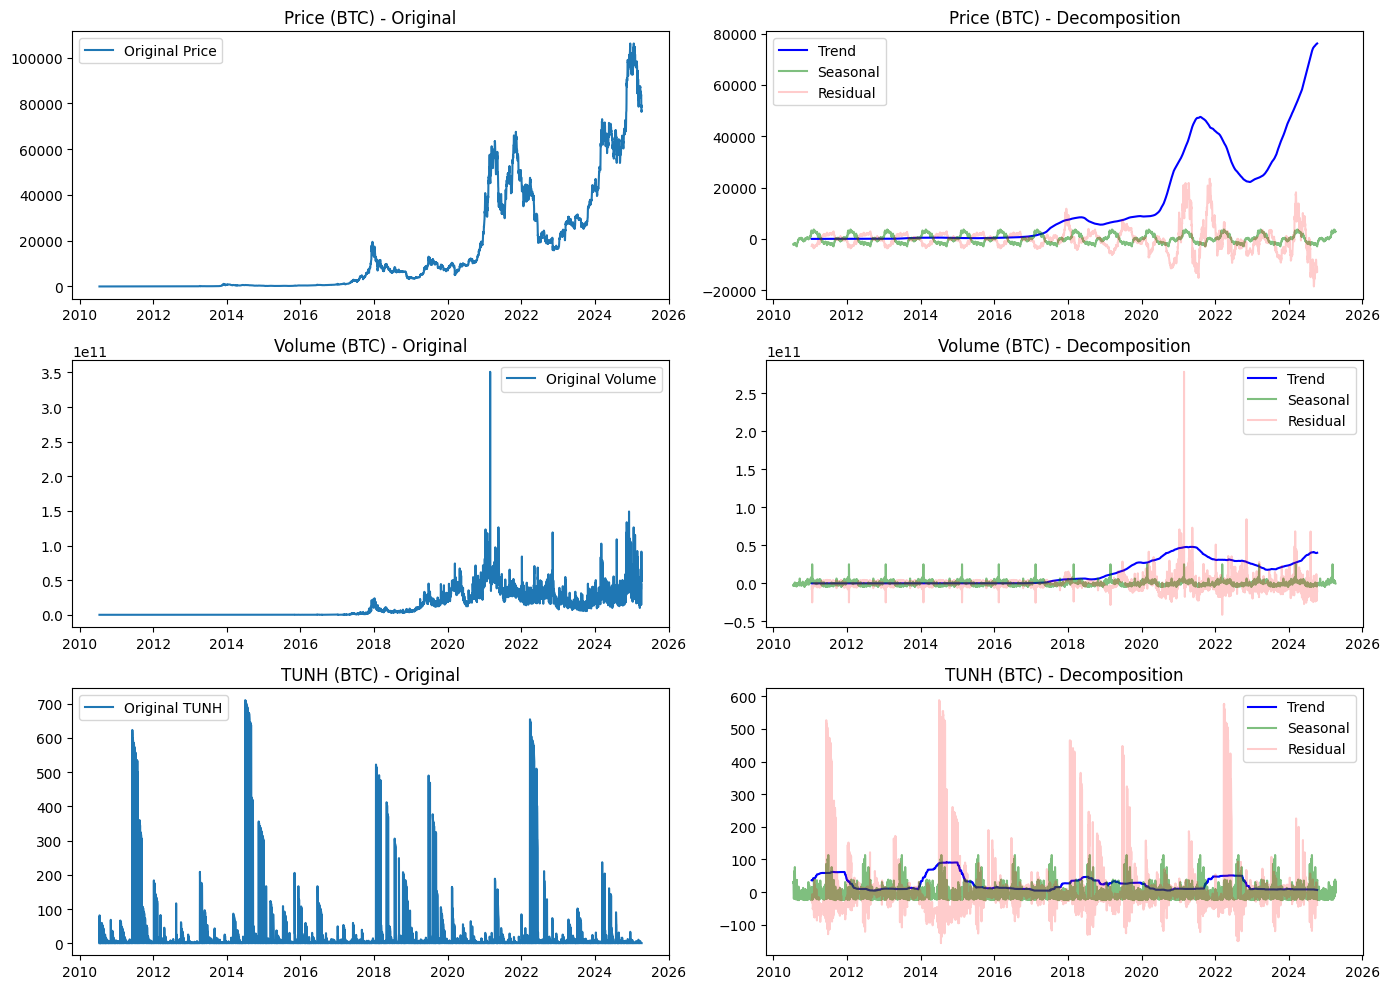

In [20]:
# Decompose the time series for 'Close', 'Volume', and 'tunh'
decomposition_price = sm.tsa.seasonal_decompose(df_btc['Close'], model='additive', period=365)
decomposition_volume = sm.tsa.seasonal_decompose(df_btc['Volume'], model='additive', period=365)
decomposition_tunh = sm.tsa.seasonal_decompose(df_btc['tunh'], model='additive', period=365)

# Create the subplots for Price, Volume, and TUNH
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Price (Close)
axes[0, 0].plot(df_btc['Close'], label='Original Price')
axes[0, 0].set_title('Price (BTC) - Original')
axes[0, 0].legend()

axes[0, 1].plot(decomposition_price.trend, label='Trend', color='blue')
axes[0, 1].plot(decomposition_price.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[0, 1].plot(decomposition_price.resid, label='Residual', color='red', alpha=0.2)
axes[0, 1].set_title('Price (BTC) - Decomposition')
axes[0, 1].legend()

# Volume
axes[1, 0].plot(df_btc['Volume'], label='Original Volume')
axes[1, 0].set_title('Volume (BTC) - Original')
axes[1, 0].legend()

axes[1, 1].plot(decomposition_volume.trend, label='Trend', color='blue')
axes[1, 1].plot(decomposition_volume.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[1, 1].plot(decomposition_volume.resid, label='Residual', color='red', alpha=0.2)
axes[1, 1].set_title('Volume (BTC) - Decomposition')
axes[1, 1].legend()

# TUNH
axes[2, 0].plot(df_btc['tunh'], label='Original TUNH')
axes[2, 0].set_title('TUNH (BTC) - Original')
axes[2, 0].legend()

axes[2, 1].plot(decomposition_tunh.trend, label='Trend', color='blue')
axes[2, 1].plot(decomposition_tunh.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[2, 1].plot(decomposition_tunh.resid, label='Residual', color='red', alpha=0.2)
axes[2, 1].set_title('TUNH (BTC) - Decomposition')
axes[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

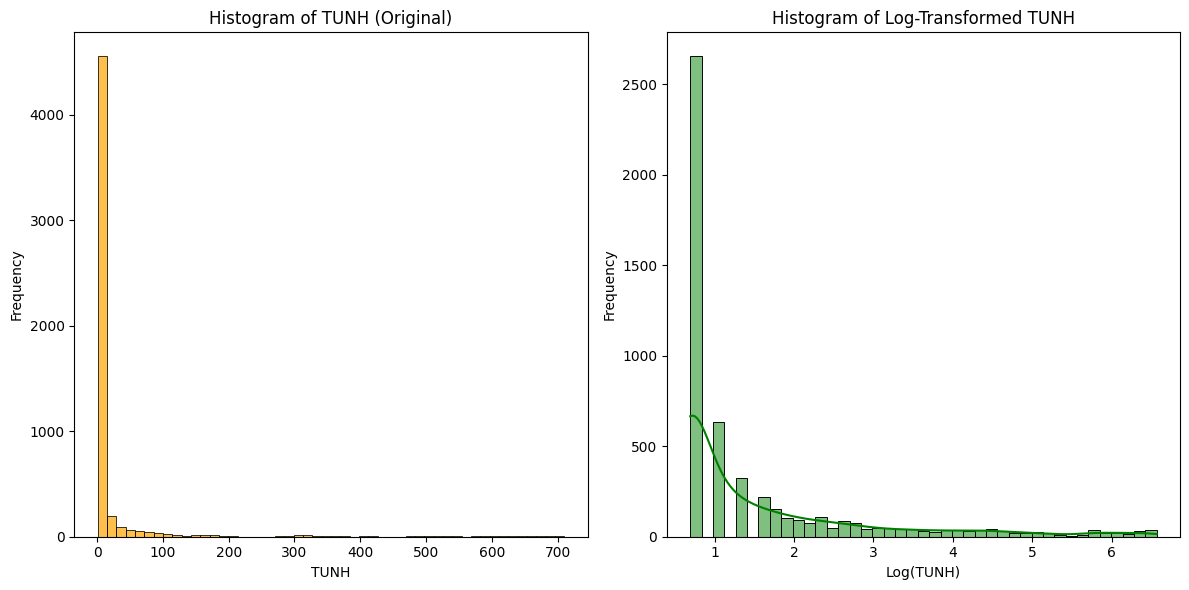

In [21]:
plt.figure(figsize=(12, 6))

# Plot original TUNH histogram
plt.subplot(1, 2, 1)
sns.histplot(df_btc['tunh'], bins=50, color='orange', edgecolor="black", alpha=0.7)  # default Matplotlib colours
plt.title('Histogram of TUNH (Original)')
plt.xlabel('TUNH')
plt.ylabel('Frequency')

# Plot transformed TUNH (log-transformed) histogram
plt.subplot(1, 2, 2)
sns.histplot(df_btc['tunh_log'], kde=True, color='green')
plt.title('Histogram of Log-Transformed TUNH')
plt.xlabel('Log(TUNH)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

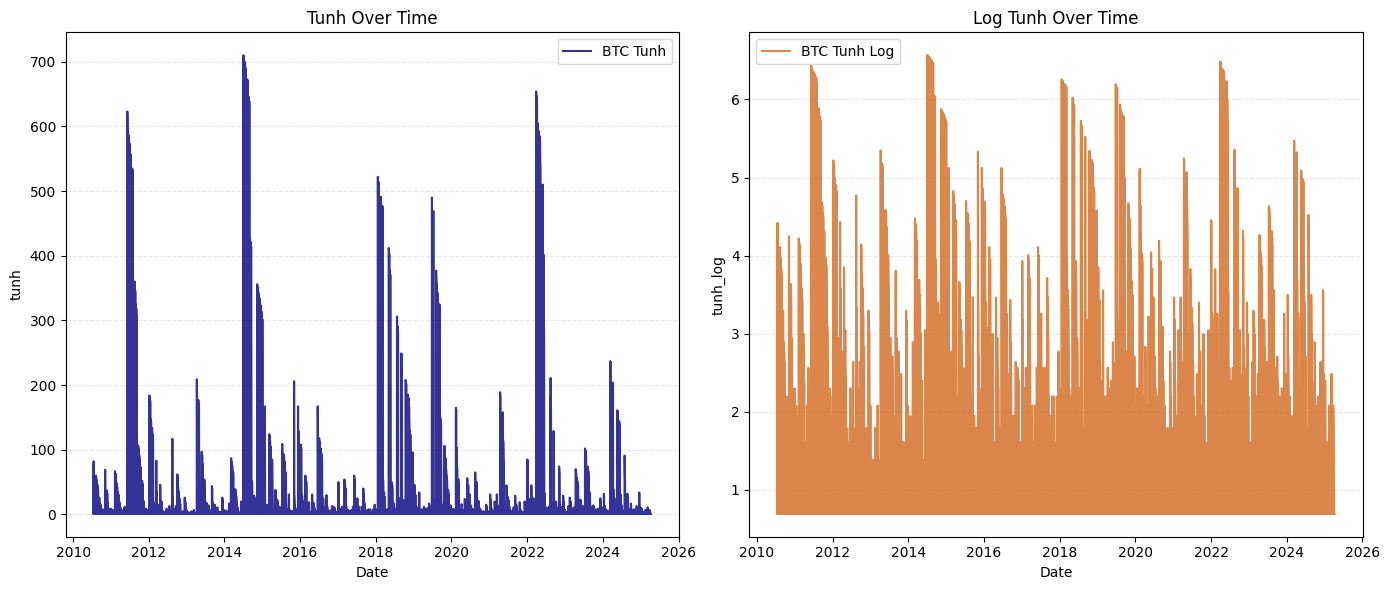

In [22]:
# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Tunh Over Time
sns.lineplot(x=df_btc["date"], y=df_btc["tunh"], color="navy", alpha=0.8, label="BTC Tunh", ax=axes[0])
axes[0].set_title("Tunh Over Time")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('tunh')
axes[0].legend()
axes[0].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[0].grid(visible=False, alpha=0.0, axis='x')

# Second plot: Log Tunh Over Time
sns.lineplot(x=df_btc["date"], y=df_btc["tunh_log"], color="chocolate", alpha=0.8, label="BTC Tunh Log", ax=axes[1])
axes[1].set_title("Log Tunh Over Time")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('tunh_log')
axes[1].legend()
axes[1].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[1].grid(visible=False, alpha=0.0, axis='x')

plt.tight_layout()
plt.show()

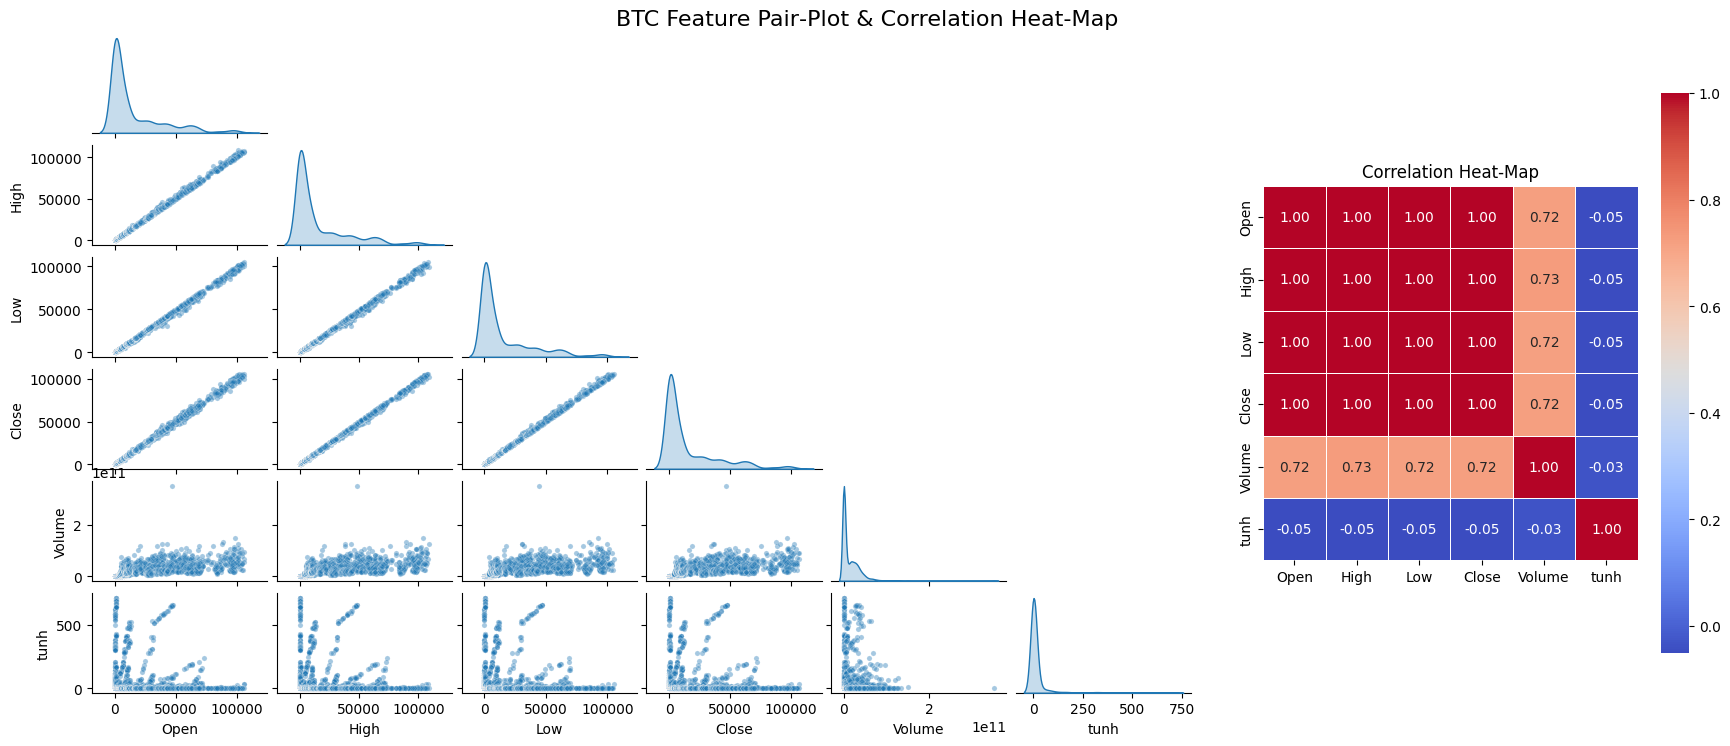

In [23]:
num_cols = ["Open", "High", "Low", "Close", "Volume", "tunh"]

g = sns.pairplot(
    df_btc[num_cols],
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.4, "s": 14}
)
g.fig.set_size_inches(18, 7)          # make it wide enough

g.fig.subplots_adjust(right=0.68)     # 68 % of width → pair‑plot; rest → heat‑map

ax_heat = g.fig.add_axes([0.72, 0.10, 0.26, 0.80])   # [left, bottom, width, height]

corr = df_btc[num_cols].corr(method="pearson")
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    ax=ax_heat
)
ax_heat.set_title("Correlation Heat‑Map", fontsize=12)

g.fig.suptitle("BTC Feature Pair‑Plot & Correlation Heat‑Map", y=1.02, fontsize=16)
plt.show()

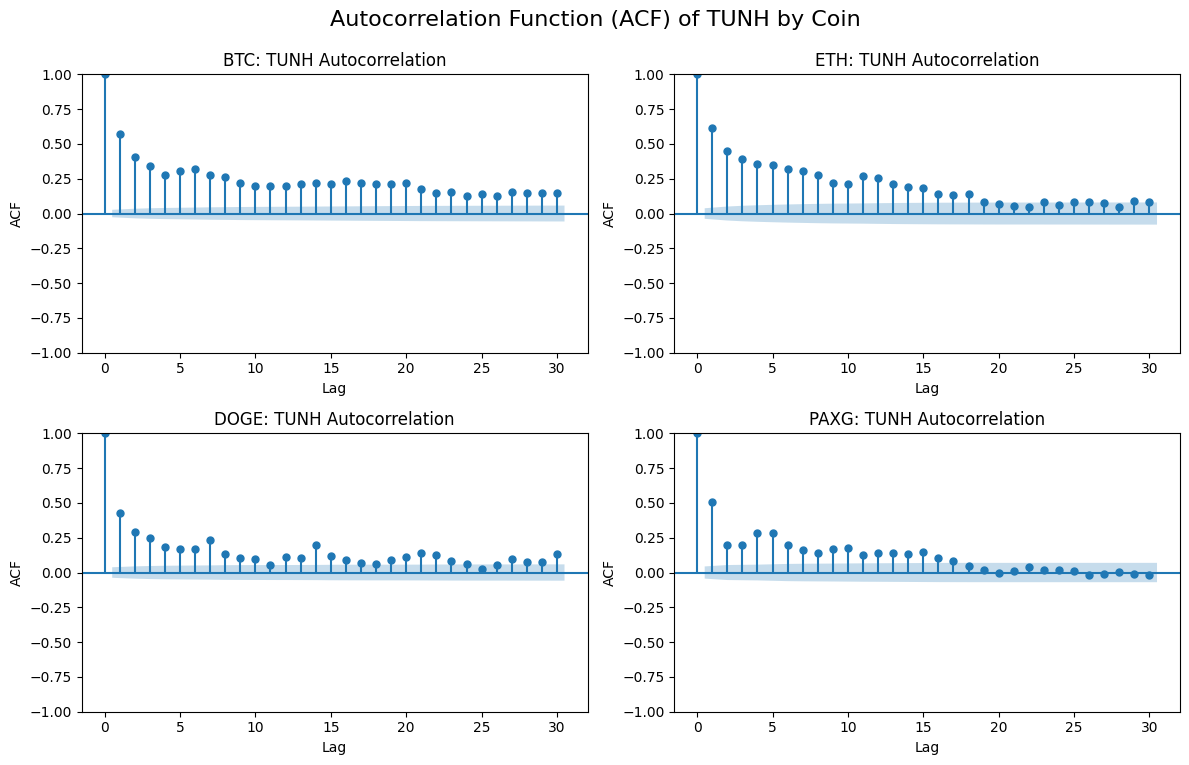

In [ ]:
# ─── 1) ACF plot for TUNH per coin ─────────────────────────────────────────────

coins = {'BTC': df_btc, 'ETH': df_eth, 'DOGE': df_doge, 'PAXG': df_paxg}
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, df) in zip(axes, coins.items()):
    plot_acf(df['tunh'].dropna(), lags=30, alpha=0.05, ax=ax)
    ax.set_title(f'{name}: TUNH Autocorrelation')
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')

fig.suptitle('Autocorrelation Function (ACF) of TUNH by Coin', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Plots/10. eda/acf_tunh.png', dpi=300, bbox_inches='tight')
plt.show()


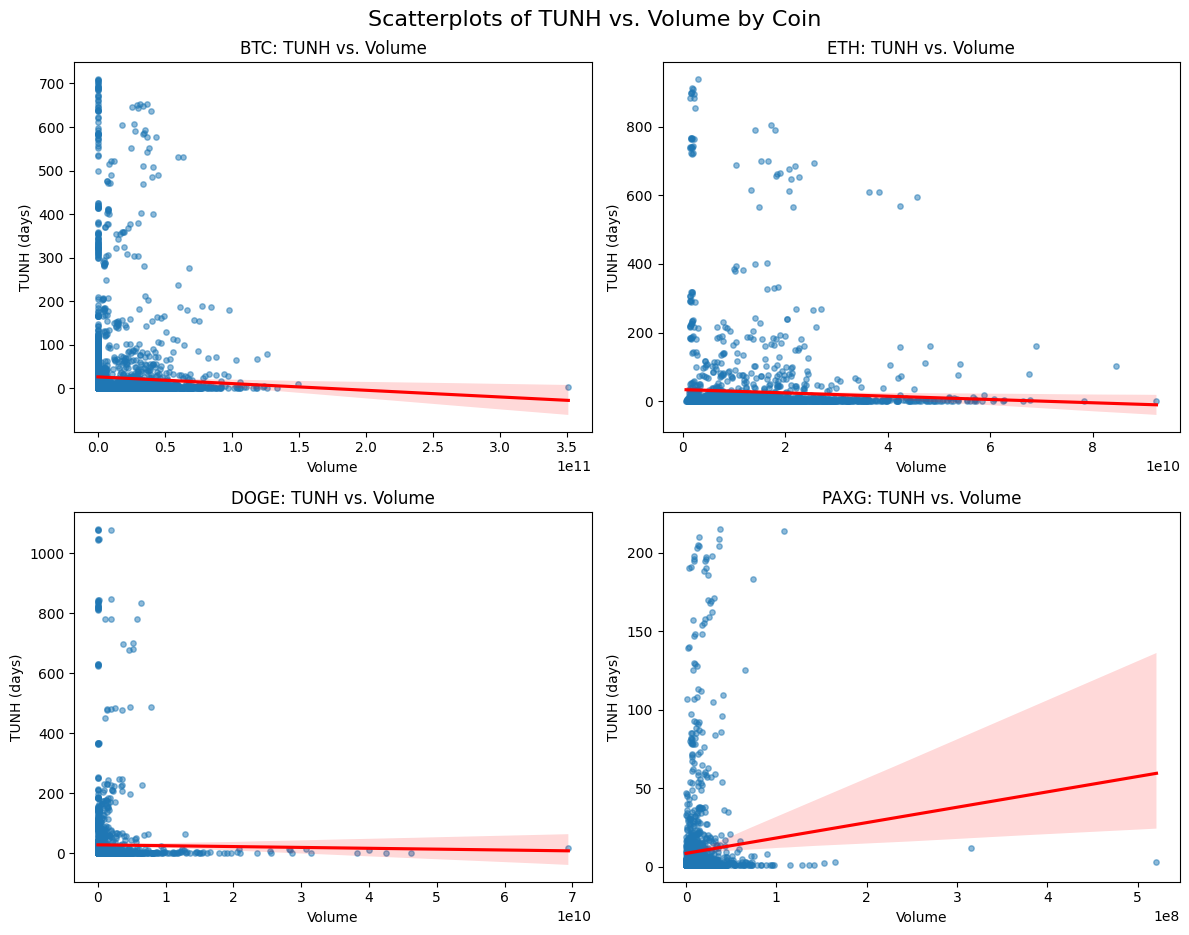

In [46]:
# ─── 2) Scatterplot of TUNH vs Volume per coin ────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, df) in zip(axes, coins.items()):
    sns.regplot(
        x='Volume', y='tunh',
        data=df.dropna(subset=['Volume','tunh']),
        scatter_kws={'s': 15, 'alpha':0.5},
        line_kws={'color':'red'},
        ax=ax
    )
    ax.set_title(f'{name}: TUNH vs. Volume')
    ax.set_xlabel('Volume')
    ax.set_ylabel('TUNH (days)')

fig.suptitle('Scatterplots of TUNH vs. Volume by Coin', fontsize=16, y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Plots/10. eda/scatter_tunh_volume.png', dpi=300, bbox_inches='tight')
plt.show()

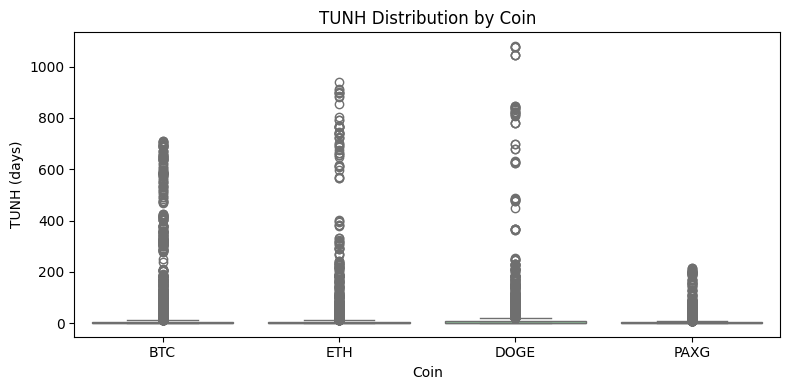

In [ ]:
# ─── 3) Boxplots comparing TUNH across coins ──────────────────────────────────

# concatenate all coins into one DF
df_list = []
for name, df in coins.items():
    temp = df[['tunh']].copy()
    temp['coin'] = name
    df_list.append(temp)
df_all = pd.concat(df_list)

plt.figure(figsize=(8,4))
sns.boxplot(x='coin', y='tunh', data=df_all, palette='pastel')
plt.title('TUNH Distribution by Coin')
plt.xlabel('Coin')
plt.ylabel('TUNH (days)')
plt.tight_layout()
plt.savefig('Plots/10. eda/boxplot_tunh.png', dpi=300, bbox_inches='tight')
plt.show()

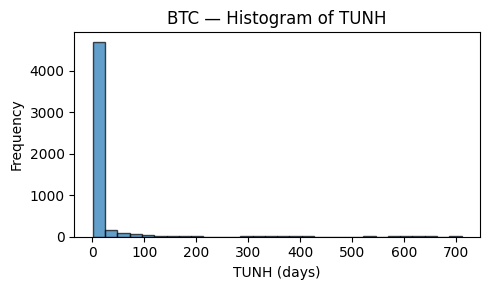

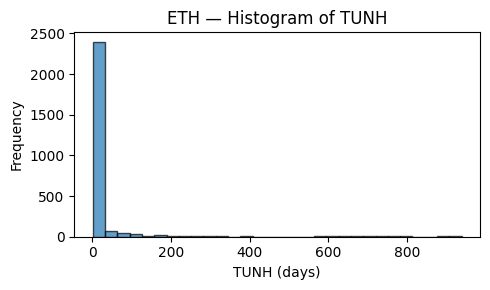

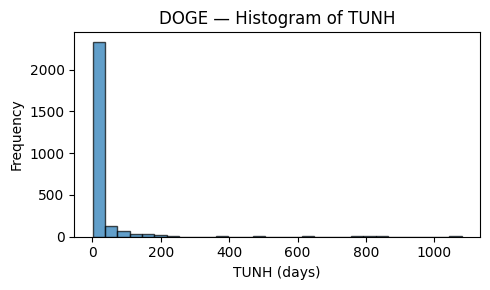

In [26]:
# ─── 4) Histograms for BTC, ETH, DOGE ────────────────────────────────────────
for name in ['BTC','ETH','DOGE']:
    df = coins[name]
    plt.figure(figsize=(5,3))
    plt.hist(df['tunh'].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{name} — Histogram of TUNH')
    plt.xlabel('TUNH (days)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

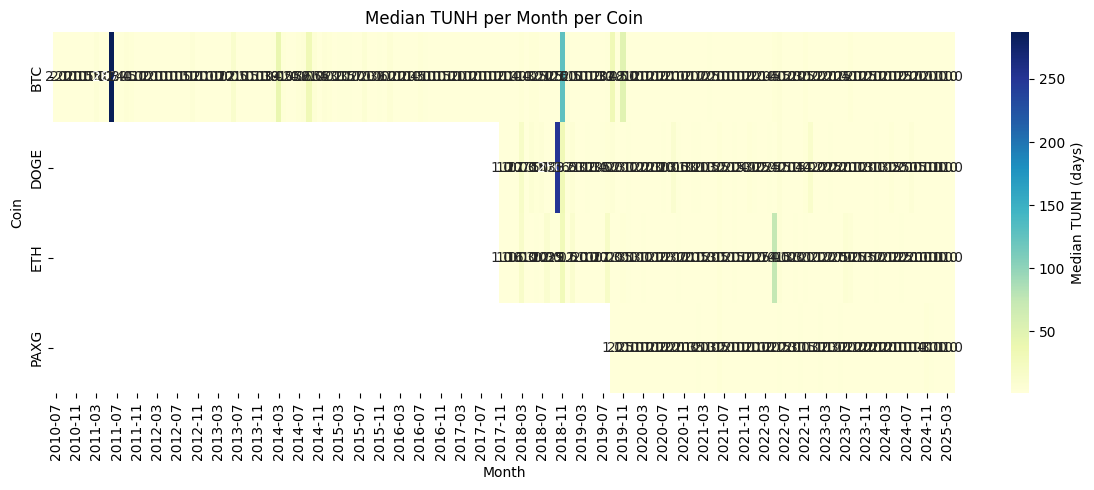

In [37]:
# ─── 5) Heatmap of median monthly TUNH per coin ──────────────────────────────
# first add a month column
df_all = df_all.reset_index().rename(columns={'index':'date'})
df_all['month'] = pd.to_datetime(df_all['Date']).dt.to_period('M')
pivot = df_all.groupby(['month','coin'])['tunh'].median().unstack()

plt.figure(figsize=(12,5))
sns.heatmap(pivot.T, annot=True, fmt=".1f", cmap='YlGnBu', cbar_kws={'label': 'Median TUNH (days)'})
plt.title('Median TUNH per Month per Coin')
plt.xlabel('Month')
plt.ylabel('Coin')
plt.tight_layout()
plt.show()